# Humpback Whale ID - data analysis

In this notebook, I examine the provided data for Kaggle's Humpack Whale ID challenge.

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
import shutil
import math
import random
from multiprocessing import Pool
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from tqdm import tqdm, tqdm_notebook

%matplotlib inline

In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
np.random.seed(42)

In [5]:
def plot_images_for_filenames(filenames, labels, rows=4, figsize=(13,8)):
    imgs = [plt.imread('data/train/' + filename) for filename in filenames]
    
    return plot_images(imgs, labels, rows, figsize)
    
        
def plot_images(imgs, labels, rows=4, figsize=(13,8)):
    # Set figure to 13 inches x 8 inches
    figure = plt.figure(figsize=figsize)

    cols = len(imgs) // rows + 1

    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(imgs[i], cmap='gray')

## Exploring the dataset

In [6]:
df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


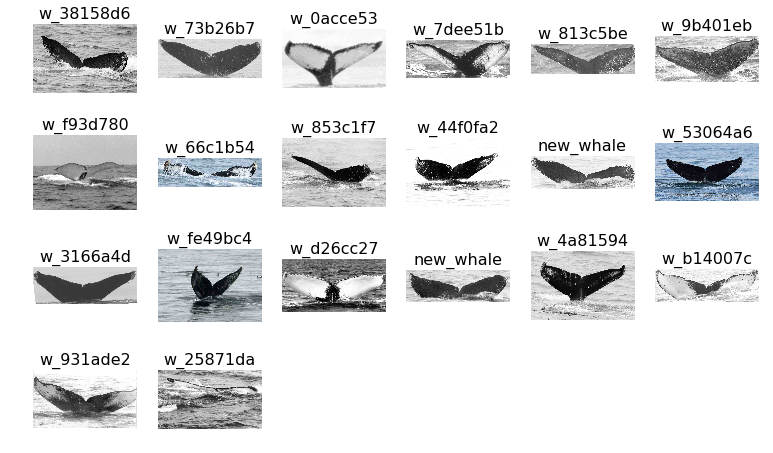

In [7]:
rand_rows = df.sample(frac=1.)[:20]
imgs = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

plot_images_for_filenames(imgs, labels)

The competition states that it's hard because: "there are only a few examples for each of 3,000+ whale ids", so let's take a look at the breakdown of number of image per category.

In [8]:
num_categories = len(df['Id'].unique())
     
print(f'Number of categories: {num_categories}')

Number of categories: 4251


There appear to be too many categories to graph count by category, so let's instead graph the number of categories by the number of images in the category.

In [9]:
size_buckets = {}

In [10]:
for i in df['Id'].value_counts().values:
    size_buckets[i] = size_buckets.get(i, 0) + 1

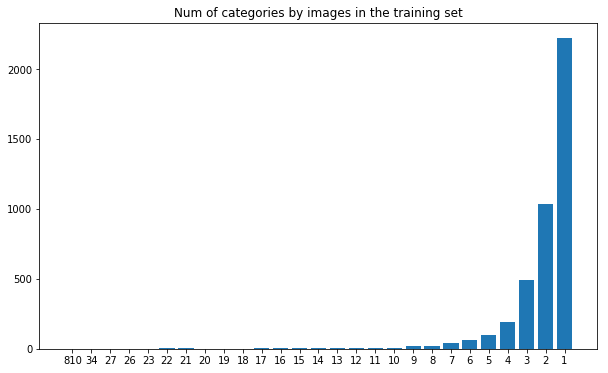

In [11]:
plt.figure(figsize=(10, 6))

plt.bar(range(len(size_buckets)), list(size_buckets.values()), align='center')
plt.xticks(range(len(size_buckets)), list(size_buckets.keys()))
plt.title("Num of categories by images in the training set")

plt.show()

As we can see, the vast majority of classes only have a single image in them. This is going to make predictions very difficult for most conventional image classification models.

In [12]:
df['Id'].value_counts().head(3)

new_whale    810
w_1287fbc     34
w_98baff9     27
Name: Id, dtype: int64

In [13]:
total = len(df['Id'])
print(f'Total images in training set {total}')

Total images in training set 9850


New whale is the biggest category with 810, followed by `w_1287fbc`. New whale, I believe, is any whale that isn't in scientist's database. Since we can pick 5 potential labels per id, it's probably going to make sense to always include new_whale in our prediction set, since there's always an 8.2% change that's the right one. Let's take a look at one of the classes, to get a sense what flute looks like from the same whale.

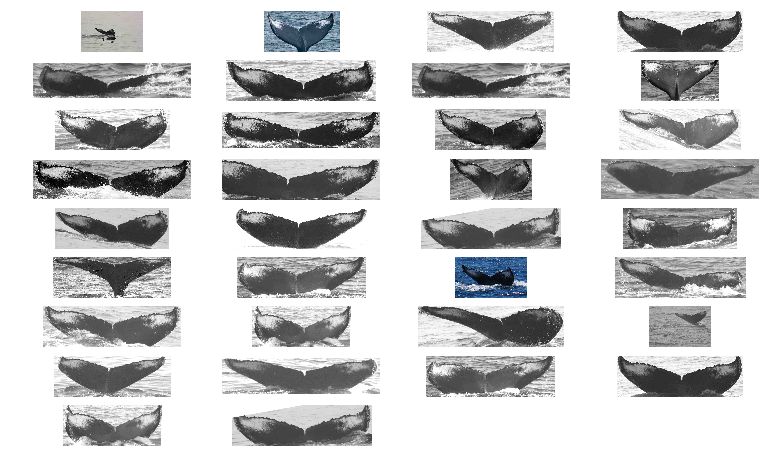

In [14]:
w_1287fbc = df[df['Id'] == 'w_1287fbc']
plot_images_for_filenames(list(w_1287fbc['Image']), None, rows=9)

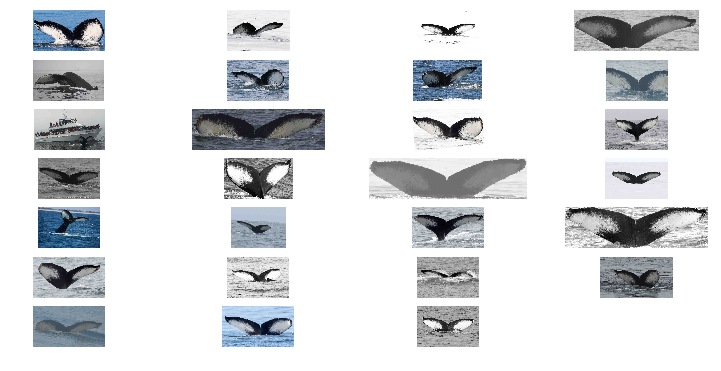

In [15]:
w_98baff9 = df[df['Id'] == 'w_98baff9']
plot_images_for_filenames(list(w_98baff9['Image']), None, rows=9)

It's very difficult to build a validation set when most classes only have 1 image, so my thinking is to perform some aggressive data augmentation on the classes with < 10 images before creating a train/validation split. Let's take a look at a few examples of whales with only one example.

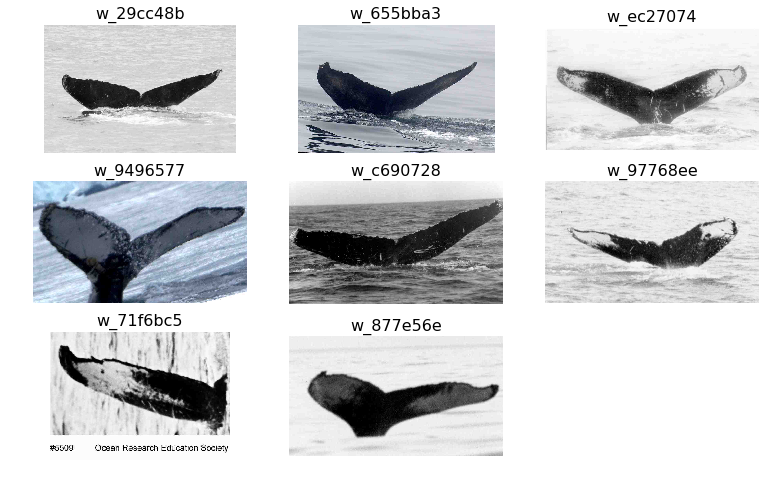

In [16]:
one_image_ids = df['Id'].value_counts().tail(8).keys()
one_image_filenames = []
labels = []
for i in one_image_ids:
    one_image_filenames.extend(list(df[df['Id'] == i]['Image']))
    labels.append(i)
    
plot_images_for_filenames(one_image_filenames, labels, rows=3)

From these small sample sizes, it seems like > 50% of images are black and white, suggesting that a good initial augementation might be to just convert colour images to greyscale and add to the training set. Let's confirm that by looking at a sample of the images.

In [17]:
def is_grey_scale(img_path, max_width_check=2):
    """Thanks to https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli"""
    im = Image.open(img_path).convert('RGB')
    w,h = im.size
    for i in range(w):
        for j in range(h):
            r,g,b = im.getpixel((i,j))
            if r != g != b: return False

        if max_width_check and i >= max_width_check:
            return True
    
    return True

In [18]:
is_grey = [is_grey_scale(f'data/train/{i}') for i in df['Image'].sample(frac=0.1)]

In [19]:
grey_perc = round(sum([i for i in is_grey]) / len([i for i in is_grey]) * 100, 2)
print(f"% of grey images: {grey_perc}")

% of grey images: 48.73


It might also be worth capturing the size of the images so we can get a sense of what we're dealing with.

In [20]:
img_sizes = Counter([Image.open(f'data/train/{i}').size for i in df['Image']])

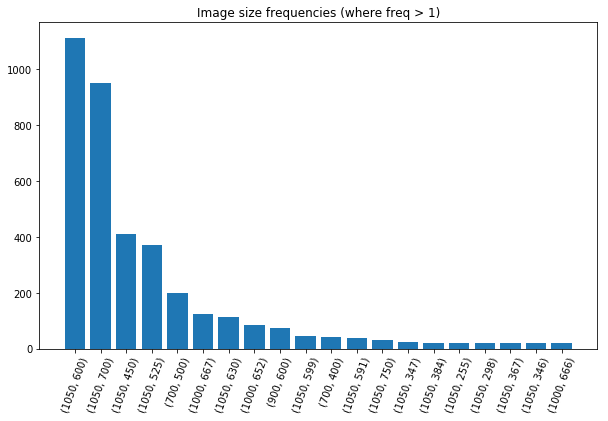

In [21]:
size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

plt.figure(figsize=(10, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=70)
plt.title("Image size frequencies (where freq > 1)")

plt.show()

## Data Augmentations

Keras comes with a number of handy data augmentions, so let's take a look at each one and see if any are going to make sense for this task.

In [22]:
from keras.preprocessing.image import (
    random_rotation, random_shift, random_shear, random_zoom,
    random_channel_shift, img_to_array)

//anaconda/envs/humpback-whale/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [23]:
img = Image.open('./data/train/ff38054f.jpg')

In [24]:
img_arr = img_to_array(img)

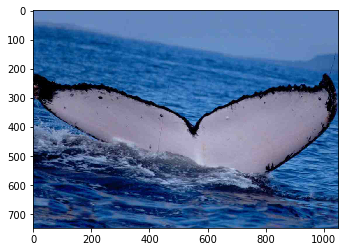

In [25]:
plt.imshow(img)

### Random rotation

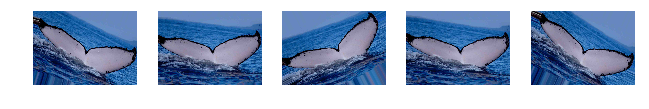

In [26]:
imgs = [
    random_rotation(img_arr, 30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest') * 255
    for _ in range(5)]
plot_images(imgs, None, rows=1)

### Random shear

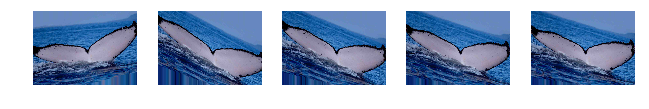

In [27]:
imgs = [
    random_shear(img_arr, intensity=0.4, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest') * 255
    for _ in range(5)]
plot_images(imgs, None, rows=1)

### Random zoom

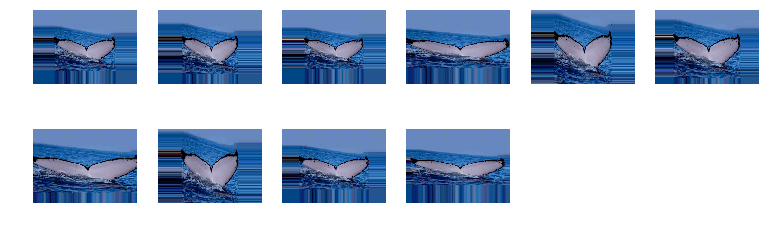

In [28]:
imgs = [
        random_zoom(img_arr, zoom_range=(0.9, 2.0), row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest') * 255
    for _ in range(10)]
plot_images(imgs, None, rows=2, figsize=(13,4))

### Grey scale

We want to ensure that all colour images also have a grey scale version.

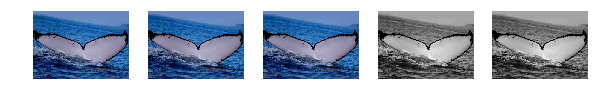

In [29]:
def random_greyscale(img, p):
    if random.random() < p:
        return np.dot(img[...,:3], [0.299, 0.587, 0.114])
    
    return img

imgs = [
    random_greyscale(img_arr, 0.5) * 255
    for _ in range(5)]
plot_images(imgs, None, rows=1, figsize=(12,6))

### Flips

Usually for side-on image sets like this we'd include a veritical flip, however, in this case the veritical alignment is requirement to differentiate between flutes, so I'll leave it out.

### All together

In [30]:
def augmentation_pipeline(img_arr):
    img_arr = random_rotation(img_arr, 18, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_shear(img_arr, intensity=0.4, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_zoom(img_arr, zoom_range=(0.9, 2.0), row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_greyscale(img_arr, 0.4)

    return img_arr

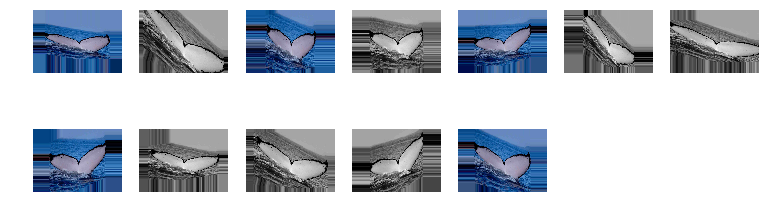

In [31]:
imgs = [augmentation_pipeline(img_arr) * 255 for _ in range(12)]
plot_images(imgs, None, rows=2, figsize=(13,4))

Think that looks pretty good. Should allow for a much larger training set, but the whale still appears to be identifiable. Unfortunately, I think the background is going to cause trouble for some of the classes with only one image: the neural network is probably going to assume it's an important part of identifying a whale. I think the trick to this competition is going to be to isolate the whale and create augmentations with different whales - we'll see.

### Create training and validation set

My approach for creating a training and validation set is going to be as follows: for each class except new_whale, I'll put one item in the dev set, then generate balanced augmentations for the remaining set, so that each class has 100 items. If the class only has one training example, I'll move it to the dev set after performing augmentations.

In [33]:
value_counts = df['Id'].value_counts()

In [34]:
def do_class(row, df, aug_path, img_size):
    """Generate augs and validation data for a single class."""
    _id, count = row
    
    os.makedirs(f'{aug_path}/train/{_id}', exist_ok=True)
    os.makedirs(f'{aug_path}/valid/{_id}', exist_ok=True)
        
    class_labels = df[df['Id'] == _id]

    # Get one at random
    rand_img = class_labels.sample(1, random_state=42)
    rand_img_path = rand_img['Image'].values[0]
    
    img = Image.open(f"data/train/{rand_img_path}")
    if img.mode != 'RGB':
        img = img.convert('RGB')
            
    img = img.resize(img_size)
    img.save(f'{aug_path}/valid/{_id}/{rand_img_path}')
    
    # Number of augmentations to create.
    num_images_per_class = 20
    num_augs_per_image = num_images_per_class // count
    img_id = rand_img_path.split('.')[0]
    
    # Generate augmentations using the single image if there only 1.
    class_labels = class_labels.drop(rand_img.index) if count != 1 else class_labels

    for row in class_labels.itertuples():
        img_id = row.Image.split('.')[0]

        # Save original image to train set, unless it's the validation image.
        if row.Image != rand_img_path:
            img = Image.open(f"data/train/{row.Image}")
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img = img.resize(img_size)
            img.save(f'{aug_path}/train/{_id}/{img_id}.jpg')
        
        for i in range(num_augs_per_image):
            Image.fromarray(
                augmentation_pipeline(np.array(img))).convert('RGB').save(
                    f'{aug_path}/train/{_id}/{img_id}.{i}.jpg')

In [35]:
class_value_counts = ((_id, count) for _id, count in value_counts.items() if _id != 'new_whale')

def _do_class(row):
    return do_class(row, df, aug_path='data/aug-100x50', img_size=(100, 50))

with Pool(processes=4) as p:
    list(tqdm(
        p.imap(_do_class, class_value_counts), total=len(value_counts.keys())))

100%|█████████▉| 4250/4251 [03:07<00:00, 22.71it/s]
